In [1]:
import pandas as pd
import numpy as np
import fastsparsegams

dfs = []
for i in range(20): 
    df = pd.read_csv('./mice-imputations/fico_imputation_feature_subset_label_not_used_{}.csv'.format(i+1))
    # df = df[df.columns[[-9, -5, -4, -3, -2, -1]]] #highest missingness prop
    dfs.append(df)

In [2]:
from sklearn.model_selection import train_test_split
train_dfs = []
test_dfs = []
for df in dfs:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df['PoorRiskPerformance'])
    train_dfs.append(train_df)
    test_dfs.append(test_df)

In [3]:
def binarize_according_to_train(train_df, test_df):
    n_train, d_train = train_df.shape
    n_test, d_test = test_df.shape
    train_no_missing, test_no_missing = {}, {}
    for c in train_df.columns:
        if c == 'PoorRiskPerformance':
            continue
        for v in list(train_df[c].quantile([0.2, 0.4, 0.6, 0.8, 1]).unique()):
            new_col_name = f'{c} <= {v}'

            new_row_train = np.zeros(n_train)
            new_row_train[train_df[c] <= v] = 1
            train_no_missing[new_col_name] = new_row_train
            
            new_row_test = np.zeros(n_test)
            new_row_test[test_df[c] <= v] = 1
            test_no_missing[new_col_name] = new_row_test

    train_no_missing['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_no_missing['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    return pd.DataFrame(train_no_missing), pd.DataFrame(test_no_missing)

In [4]:
trains = []
tests = []
y_trains = []
y_tests = []
X_trains = []
X_tests = []

for train_df, test_df in zip(train_dfs, test_dfs):
    train, test = binarize_according_to_train(train_df, test_df)
    trains.append(train)
    tests.append(test)
    
    y_trains.append(train['PoorRiskPerformance'].values)
    y_tests.append(test['PoorRiskPerformance'].values)
    
    X_trains.append(train[train.columns[:-1]].values)
    X_tests.append(test[test.columns[:-1]].values)

In [5]:
models = []
for X_train, y_train in zip(X_trains, y_trains):
    model = fastsparsegams.fit(
        X_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
    )
    models.append(model)

In [6]:
#recover coefficients and train/test probabilities
def eval_model(model, X_train, X_test): 
    coeffs = np.zeros((len(model.lambda_0[0]), X_train.shape[1]))
    train_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))
    test_probs = np.zeros((len(model.lambda_0[0]), X_test.shape[0]))

    for i, lamby in enumerate(model.lambda_0[0]): 
        train_probs[i] = model.predict(X_train.astype(float),lambda_0=lamby).reshape(-1)
        test_probs[i] = model.predict(X_test.astype(float),lambda_0=lamby).reshape(-1)

        coeffs[i] = (model.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    return train_probs, test_probs, coeffs

In [7]:
all_train_probs = []
all_test_probs = []
all_coeffs = []
all_trainacc = []
all_testacc = []
all_num_terms = []
for model, X_train, X_test, y_train, y_test in zip(models, X_trains, X_tests, y_trains, y_tests):
    train_probs, test_probs, coeffs = eval_model(model, X_train, X_test)
    trainacc = ((train_probs > 0.5) == y_train).mean(axis=1)
    testacc = ((test_probs > 0.5) == y_test).mean(axis=1)
    num_terms = (coeffs != 0).sum(axis=1)

    all_num_terms.append(num_terms)
    all_trainacc.append(trainacc)
    all_testacc.append(testacc)
    all_train_probs.append(train_probs)
    all_test_probs.append(test_probs)
    all_coeffs.append(coeffs)

Text(0.5, 0, '# Nonzero coefficients')

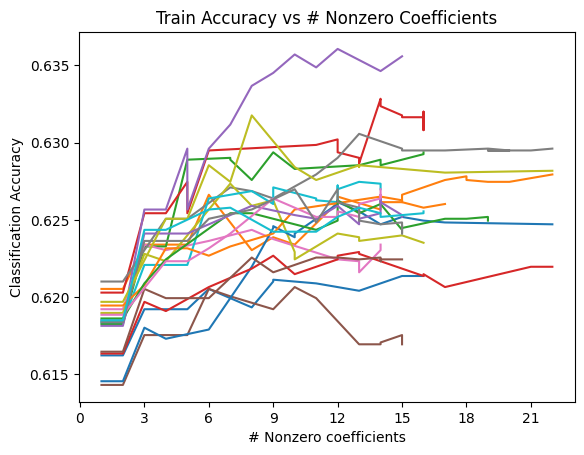

In [8]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Train Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)

for idx, (trainacc, num_terms) in enumerate(zip(all_trainacc, all_num_terms)):
    plt.plot(num_terms[num_terms > 0], trainacc[num_terms > 0], label='train accuracy for imputed model ' + str(idx+1))
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

# plt.legend()

Text(0.5, 0, '# Nonzero coefficients')

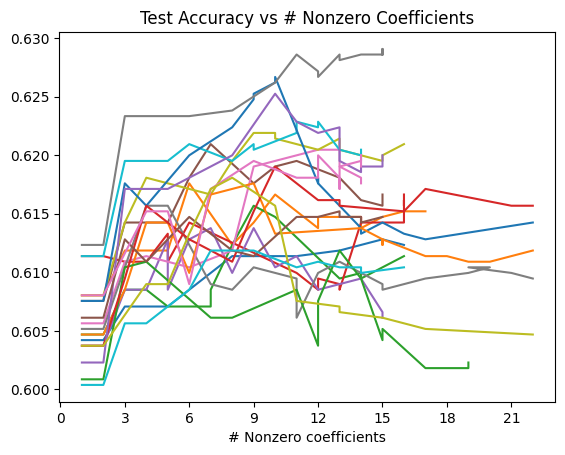

In [9]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
for idx, (testacc, num_terms) in enumerate(zip(all_testacc, all_num_terms)):
    plt.plot(num_terms[num_terms > 0], testacc[num_terms > 0], label='test accuracy for imputed model ' + str(idx+1))

# plt.plot(num_terms[num_terms > 0], testacc[num_terms > 0], label='test accuracy,')
plt.xlabel('# Nonzero coefficients')

# plt.legend()

In [10]:
# Aggregate results

In [11]:
#concatenate train_dfs, then binarize
merged_train_df = pd.concat(train_dfs)
merged_test_df = pd.concat(test_dfs)
merged_train, merged_test = binarize_according_to_train(merged_train_df, merged_test_df)

In [12]:
merged_y_train = merged_train['PoorRiskPerformance'].values
merged_X_train = merged_train[merged_train.columns[:-1]].values

In [13]:
aggregate_model = fastsparsegams.fit(
    merged_X_train.astype(float), merged_y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
)

In [14]:
merged_X_test = merged_test[merged_test.columns[:-1]].values
merged_y_test = merged_test['PoorRiskPerformance'].values

In [15]:
merged_train_probs, merged_test_probs, merged_coeffs = eval_model(aggregate_model, merged_X_train, merged_X_test)

In [16]:
merged_train_probs.shape

(100, 167340)

In [17]:
# average over the preds for all the different imputations
imputation_offsets = np.arange(len(dfs)) * int(merged_test_probs.shape[1]/len(dfs))

averaged_probs = []
for i in range(int(merged_test_probs.shape[1]/len(dfs))):
    #todo find more numpythonic way to do this
    averaged_probs.append(merged_test_probs[:, i + imputation_offsets].mean(axis=1))

In [18]:
averaged_probs = np.array(averaged_probs).T

In [19]:
merged_y_test.shape[0]

41840

In [20]:
merged_trainacc = ((merged_train_probs > 0.5) == merged_y_train).mean(axis=1)
merged_testacc = ((averaged_probs > 0.5) == merged_y_test[:int(merged_y_test.shape[0]/len(dfs))]).mean(axis=1)
merged_num_terms = (merged_coeffs != 0).sum(axis=1)

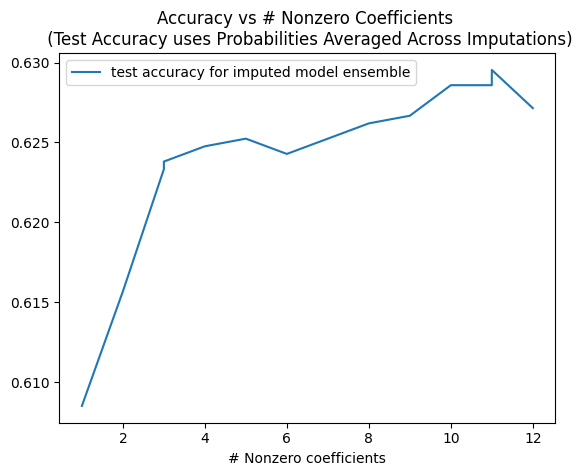

In [21]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Accuracy vs # Nonzero Coefficients \n (Test Accuracy uses Probabilities Averaged Across Imputations)')#\n (Other than intercept)
plt.plot(merged_num_terms[merged_num_terms > 0], merged_testacc[merged_num_terms > 0], label='test accuracy for imputed model ensemble')
# plt.plot(merged_num_terms[merged_num_terms > 0], merged_trainacc[merged_num_terms > 0], label='train accuracy for imputed model ensemble')


# plt.plot(num_terms[num_terms > 0], testacc[num_terms > 0], label='test accuracy,')
plt.xlabel('# Nonzero coefficients')

plt.legend()

In [22]:
# average over the preds for all the different imputations
averaged_preds = []
for i in range(int(merged_test_probs.shape[1]/len(dfs))):
    #todo find more numpythonic way to do this
    averaged_preds.append((merged_test_probs[:, i + imputation_offsets] > 0.5).mean(axis=1) > 0.5)

In [23]:
averaged_preds = np.array(averaged_preds).T

In [24]:
merged_testacc_majority_vote = (averaged_preds == y_test).mean(axis= 1)

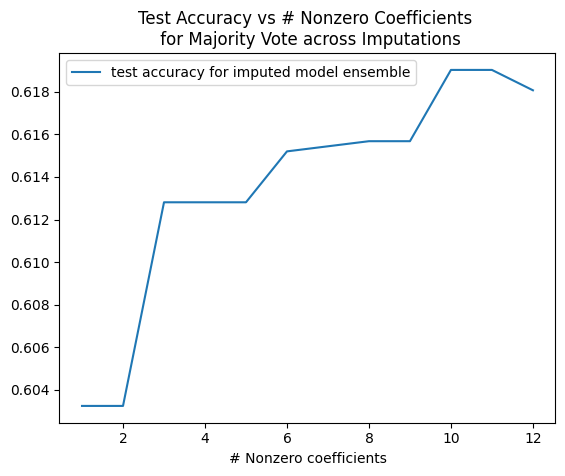

In [25]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Test Accuracy vs # Nonzero Coefficients \n for Majority Vote across Imputations')#\n (Other than intercept)
plt.plot(merged_num_terms[merged_num_terms > 0], merged_testacc_majority_vote[merged_num_terms > 0], label='test accuracy for imputed model ensemble')

# plt.plot(num_terms[num_terms > 0], testacc[num_terms > 0], label='test accuracy,')
plt.xlabel('# Nonzero coefficients')

plt.legend()

In [26]:
#TODO: - try more imputations
#      - compare this approach and fastsparsegams with missingness on the full data set rather than just half